# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Dropout regularization in practice
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [11]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np  
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

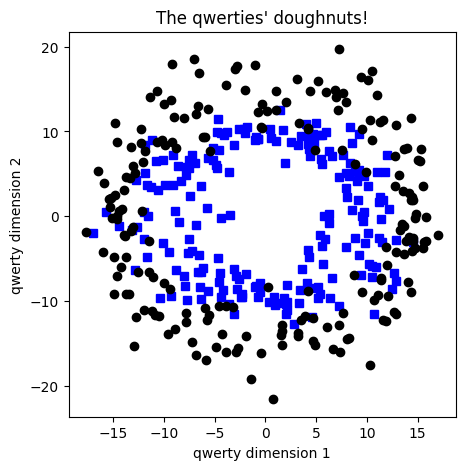

In [14]:
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [45]:
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_X, train_y)
test_data = TensorDataset(test_X, test_y)

In [47]:
BATCH = 4
BATCHSIZE = int(train_data.tensors[0].shape[0]/BATCH) # train_data.tensors[0] 是X 1是label

train_loader = DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

BATCHSIZE

80

In [104]:
class FFN(nn.Module):
    def __init__(self, dropoutRate) -> None:
        super().__init__()

        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        
        self.dr = dropoutRate

    def forward(self, X):
        X = F.relu(self.input(X))
        X = F.dropout(X, self.dr, training=self.training)

        X = F.relu(self.hidden(X))
        X = F.dropout(X, self.dr, training=self.training)

        X = F.relu(self.output(X))

        return X

In [105]:
net_tmp = FFN(.25)
data_temp = torch.randn((10, 2))
_y_hat = net_tmp(data_temp)
_y_hat

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

## Functions to create and train the net

In [106]:
def createModels(dropout):
    ffn = FFN(dropout)
    criteria = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ffn.parameters(), lr=.002)
    return ffn, criteria, optimizer

In [107]:
#train

def train(ffn, criteria, optimizer, epoches = 1000):
    trainAcc = []
    testAcc  = [] 

    for _ in range(epoches):
        ffn.train() #switch on train mode
        batchAcc = []

        for X_train, y_train in train_loader:
            _y_pred = ffn(X_train)
            _loss = criteria(_y_pred, y_train)

            # backprop
            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()

            batchAcc.append(100 * torch.mean(((_y_pred > 0) == y_train).float()).item())
        
        trainAcc.append(np.mean(batchAcc))

        ffn.eval() # switch off training
        X_test, y_test = next(iter(test_loader)) # extract X,y from test dataloader
        y_pred = ffn(X_test)
        testAcc.append(100 * torch.mean(((y_pred > 0) == y_test).float()).item())

    return trainAcc, testAcc


In [108]:
dropoutrate = .25
ANNQC,lossfun,optimizer = createModels(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = train(ANNQC,lossfun,optimizer)

In [109]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

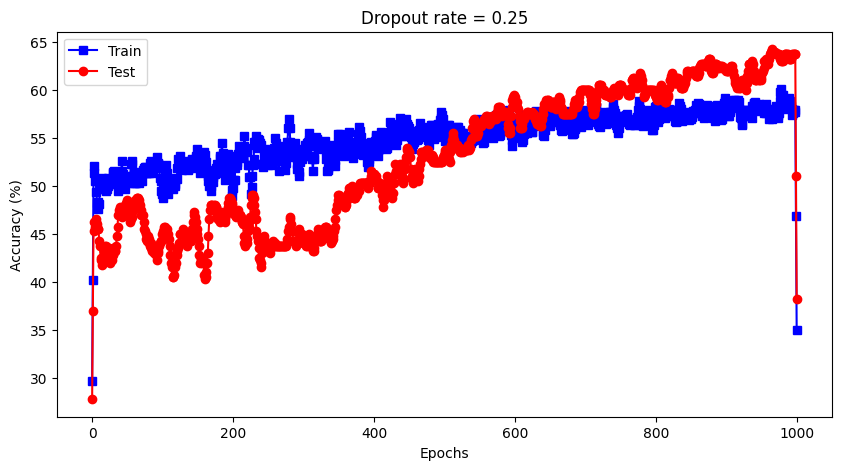

In [110]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

## Experiment

In [111]:
# run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createModels(dropoutRates[di])
  trainAcc,testAcc = train(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])


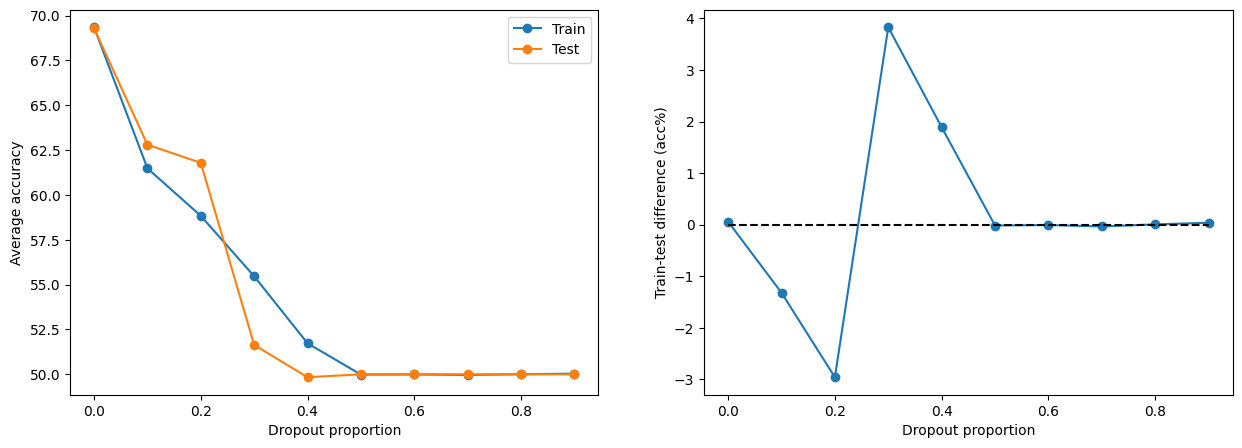

In [112]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()